<a href="https://colab.research.google.com/github/Bharathkrishnamurthy/21Day_21_ML-_project/blob/main/DAY4_project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Heart Disease Prediction (Classification) 🩺

**Project Objective:** To build a machine learning model that can accurately predict whether a patient has heart disease based on a set of medical attributes. This project will serve as a comprehensive introduction to classification, one of the most common types of machine learning problems.


### Core Concepts We'll Cover:
1.  **Classification Fundamentals:** Understanding the goal of predicting a discrete category.
2.  **Exploratory Data Analysis (EDA) for Classification:** Analyzing features to find patterns that distinguish between classes.
3.  **Data Preprocessing:** Preparing data for classification models using encoding and feature scaling.
4.  **Model Building:** Training and comparing a simple baseline model (Logistic Regression) with an advanced ensemble model (Random Forest).
5.  **Model Evaluation:** Mastering key classification metrics like Accuracy, Precision, Recall, F1-Score, and interpreting the Confusion Matrix.
6.  **Feature Importance:** Identifying the most influential medical factors for predicting heart disease.

### **Theoretical Concept: What is Classification?**

Classification is a type of supervised machine learning task where the goal is to predict a **discrete category or class label**. This is different from regression, where we predict a continuous numerical value.

**Classification vs. Regression:**
- **Classification:** Is this email spam or not spam? (Two classes)
- **Regression:** What will be the price of this house? (Continuous value)

In this project, our goal is to predict one of two classes for a patient: `0` (No Heart Disease) or `1` (Has Heart Disease). This is a **binary classification** problem.

### Step 1: Setup - Importing Libraries and Loading Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

# set grid as white
sns.set_style('whitegrid')


In [ ]:
# download dataset using kaggle hub
print("Downloading datasets!...........")


# Download latest version
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# load dataset  from path
file_path = f'{path}/heart_disease_uci.csv'
df=pd.read_csv(file_path)


print("Path to dataset files:", path)
print("dataset downloaded sucessfully")
print("dataset shape is:",df.shape)
df.head()

### Step 2: Exploratory Data Analysis (EDA)
Before building any models, we need to understand our data deeply. We'll look at the distribution of our target variable, the characteristics of our features, and how they relate to the presence of heart disease.


In [ ]:
print("Data information")
df.info()

print("\nDescriptive Data")
df.describe()

print("\nChecking for missing values:")
print(df.isna().sum().sum())

#### 2.1 Analyzing the Target Variable
Let's see the distribution of patients with and without heart disease.

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x="num",data=df,palette='plasma',hue='num',legend=False)
plt.title("Distribution of Patients with and without Heart Disease")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

2.2 Analysing Feature VS Target

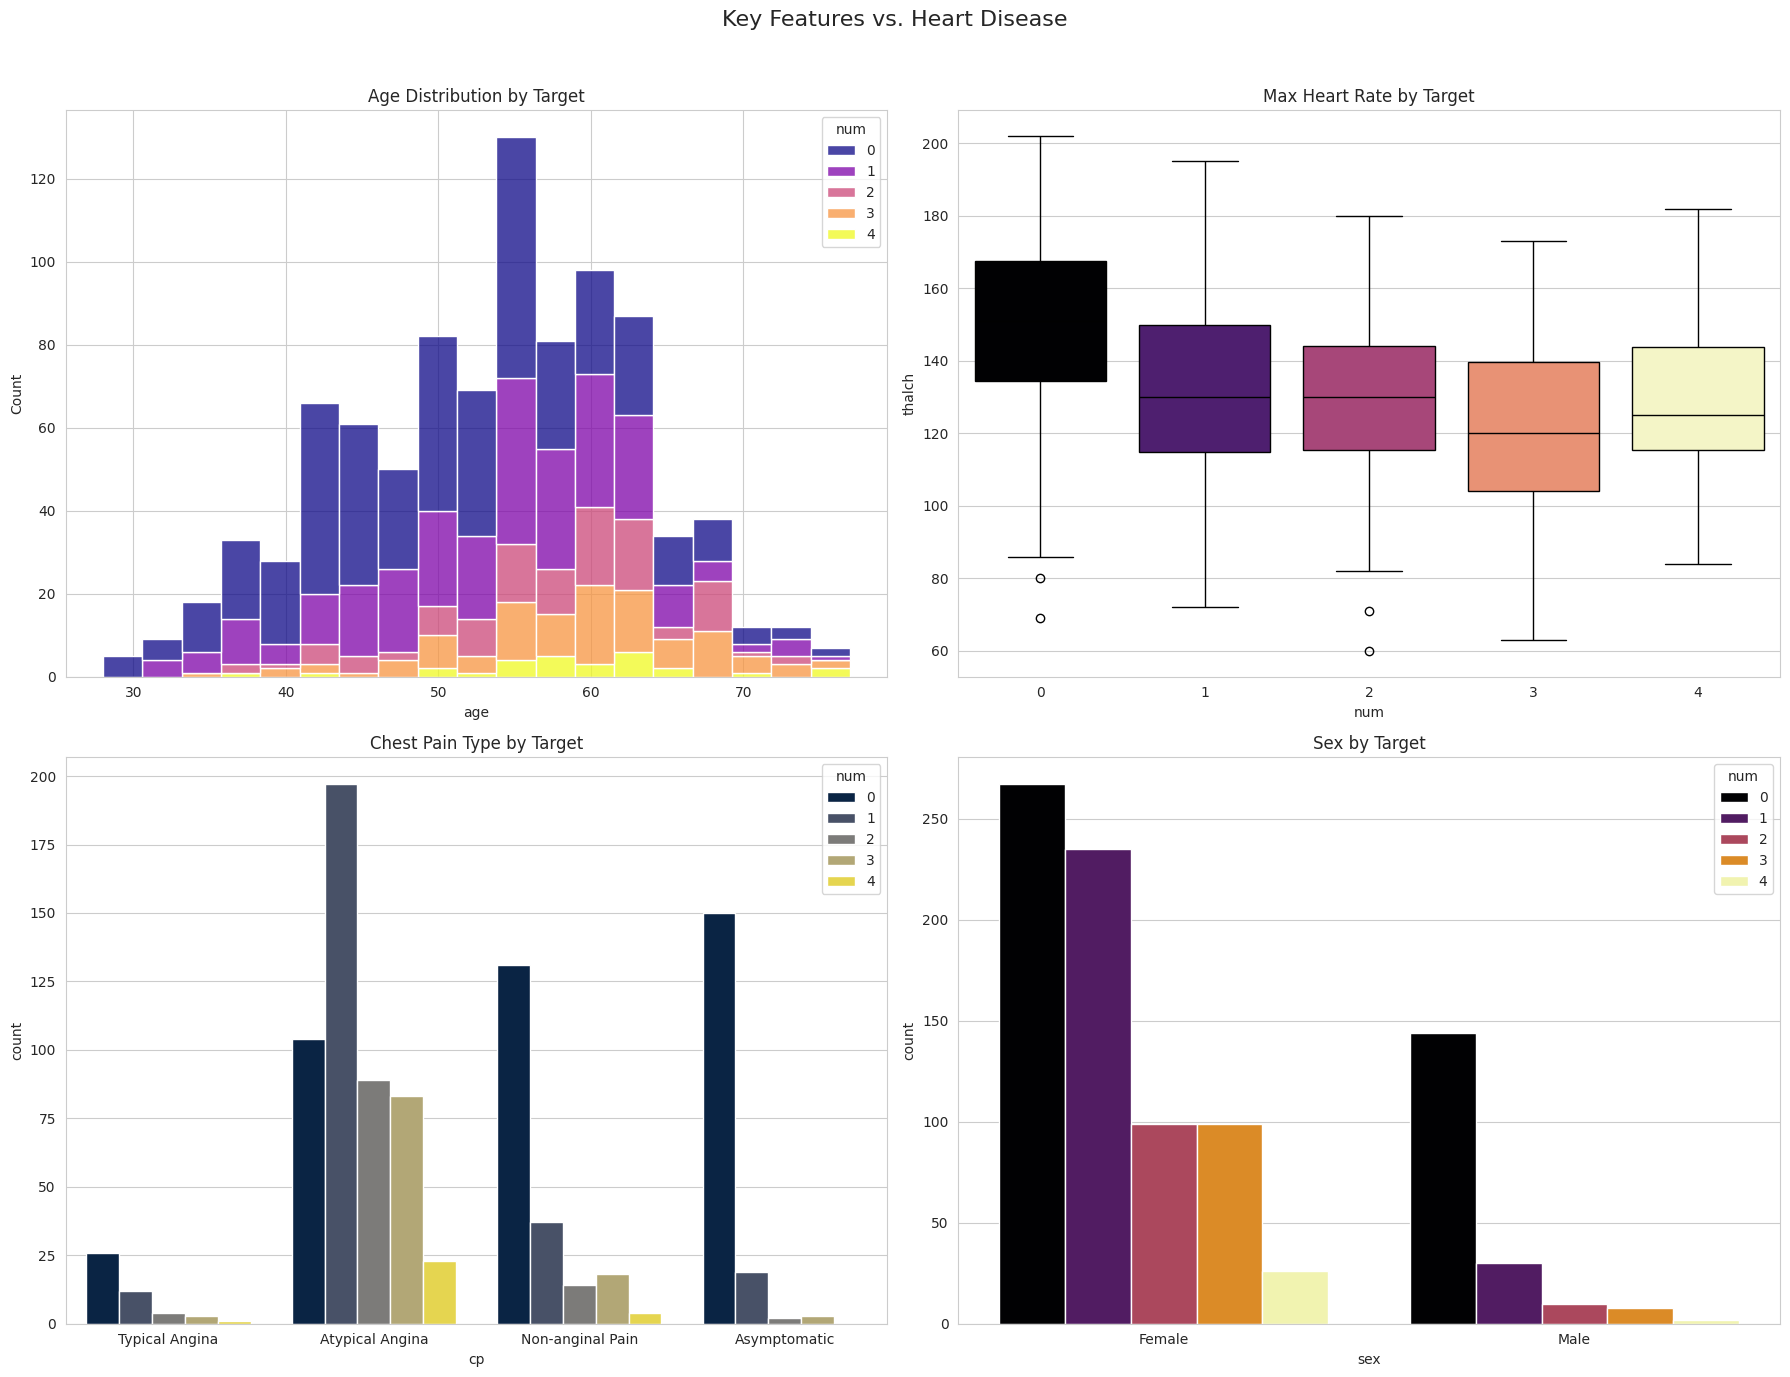

In [36]:
# Let's visualize the relationship between key features and the target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Insights:**
- **Max Heart Rate (`thalach`):** Patients with heart disease tend to have a lower maximum heart rate.
- **Chest Pain (`cp`):** Patients with chest pain types 1 and 2 (Atypical and Non-anginal) are more likely to have heart disease. Surprisingly, those with type 0 (Typical Angina) are less likely, and those with asymptomatic pain (type 3) are very likely to have the disease.
- **Sex:** A higher proportion of females in this dataset have heart disease compared to males.

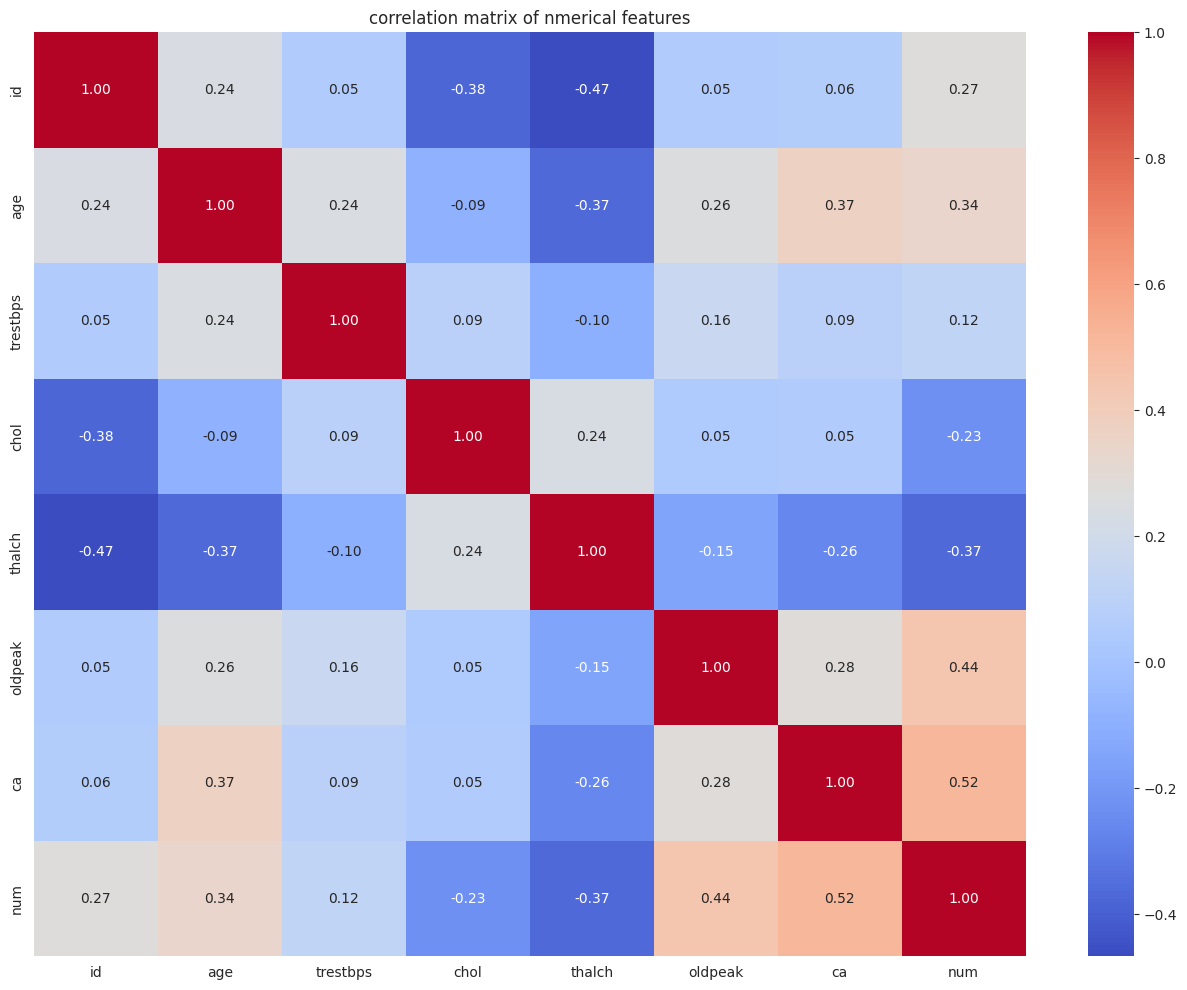

In [37]:
# correlation matrix
plt.figure(figsize=(16,12))
# select only numerical columns for correlation calculation
numerical_df=df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(),annot=True,cmap='coolwarm',fmt='.2f')
plt.title("correlation matrix of nmerical features")
plt.show()

### Step 3: Data Preprocessing
Even though the data is clean, we need to prepare it for our models. This involves:
1.  **Separating features (X) and target (y).**
2.  **Identifying categorical features** that need to be encoded.
3.  **One-Hot Encoding** categorical features to convert them into a numerical format.
4.  **Scaling numerical features** so they are on a similar scale.

## **Theoretical Concept: Scikit-Learn Pipelines**

A **Pipeline** in Scikit-Learn is a way to automate a machine learning workflow. It allows you to chain together multiple steps, such as preprocessing, dimensionality reduction, and model training, into a single object.

**Why use Pipelines?**

1.  **Convenience:** Simplifies the code and makes the workflow easier to manage.
2.  **Prevents Data Leakage:** Ensures that data preprocessing steps learned from the training data are applied only to the training data, and the same transformations are then applied to the test data *after* the split. This prevents information from the test set from "leaking" into the training process.
3.  **Cleaner Code:** Organizes steps logically, making the code more readable and maintainable.
4.  **Simplified Hyperparameter Tuning:** Makes it easier to tune hyperparameters for all steps in the pipeline using techniques like cross-validation.

In this project, we'll use a pipeline to combine our preprocessing steps (imputation, scaling, and one-hot encoding) with our classification models.

In [38]:
from sklearn.impute import SimpleImputer

# define features (X) and target(y)
X=df.drop('num',axis=1)
y=df['num']

# drop id and dataset features as they are not feature
X=X.drop(['id','dataset'],axis=1)

# indentify categorical and numerical features
numerical_features=X.select_dtypes(include=np.number).columns
categorical_features=X.select_dtypes(exclude=np.number).columns

print("Numerical Features:",numerical_features)
print("Categorical Features:",categorical_features)

# split data into training and testing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5,random_state=42,stratify=y)

Numerical Features: Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca'], dtype='object')
Categorical Features: Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], dtype='object')


### Step 4: Model Building & Training
We will build two models and wrap them in a Scikit-Learn

#### **Theoretical Concept: Classification Models**

Let's dive into more detail on the classification models we are using:

*   **Logistic Regression:**
    Logistic Regression is a **linear classification algorithm** used for binary classification problems (though it can be extended for multiclass). Despite the name "regression," it's a classification method. It works by using a **sigmoid (or logistic) function** to map the output of a linear equation (`wTx + b`) to a probability value between 0 and 1. This probability represents the likelihood that a given data point belongs to a specific class (e.g., the positive class). A threshold (commonly 0.5) is then applied to these probabilities to assign the class label. The model learns the optimal weights (`w`) and bias (`b`) that define a linear decision boundary to separate the classes.

*   **Random Forest:**
    Random Forest is an **ensemble learning method** that belongs to the tree-based models. It builds a large number of **decision trees** during training. Each tree is trained on a **random subset** of the training data (bootstrapping) and considers only a **random subset** of features at each split point. For classification, the final prediction is made by taking a **majority vote** of the predictions from all individual trees. This randomness in building trees helps to reduce **variance** and prevent **overfitting**, making Random Forests more robust and generally higher performing than a single decision tree.

*   **Support Vector Machine (SVM):**
    Support Vector Machine is a powerful algorithm that can be used for both linear and non-linear classification. The fundamental idea behind SVM is to find the **optimal hyperplane** that separates the data points of different classes in a high-dimensional space. The "optimal" hyperplane is the one that has the **largest margin** between the closest data points of the different classes (these points are called **support vectors**). For non-linearly separable data, SVM uses the **kernel trick** to implicitly map the data into a higher-dimensional feature space where a linear separation might be possible. Common kernels include the linear kernel, polynomial kernel, and Radial Basis Function (RBF) kernel.

*   **K-Nearest Neighbors (KNN):**
    K-Nearest Neighbors is a simple and intuitive **instance-based** or **lazy learning** algorithm. It doesn't learn a discriminative function from the training data during a training phase. Instead, it memorizes the training dataset. To classify a new, unseen data point, it calculates the **distance** (e.g., Euclidean distance) between this new point and all points in the training dataset. It then identifies the **'k' nearest data points**. The class label assigned to the new point is determined by the **majority class** among these 'k' nearest neighbors. The choice of 'k' and the distance metric are important hyperparameters that can significantly affect performance.

#### 4.1 Model 1: Logistic Regression (Baseline)

Train NaNs: 0 Test NaNs: 0
Accuracy Score: 0.5760869565217391
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80       206
           1       0.52      0.52      0.52       132
           2       0.23      0.13      0.16        55
           3       0.22      0.23      0.22        53
           4       0.00      0.00      0.00        14

    accuracy                           0.58       460
   macro avg       0.34      0.35      0.34       460
weighted avg       0.54      0.58      0.55       460



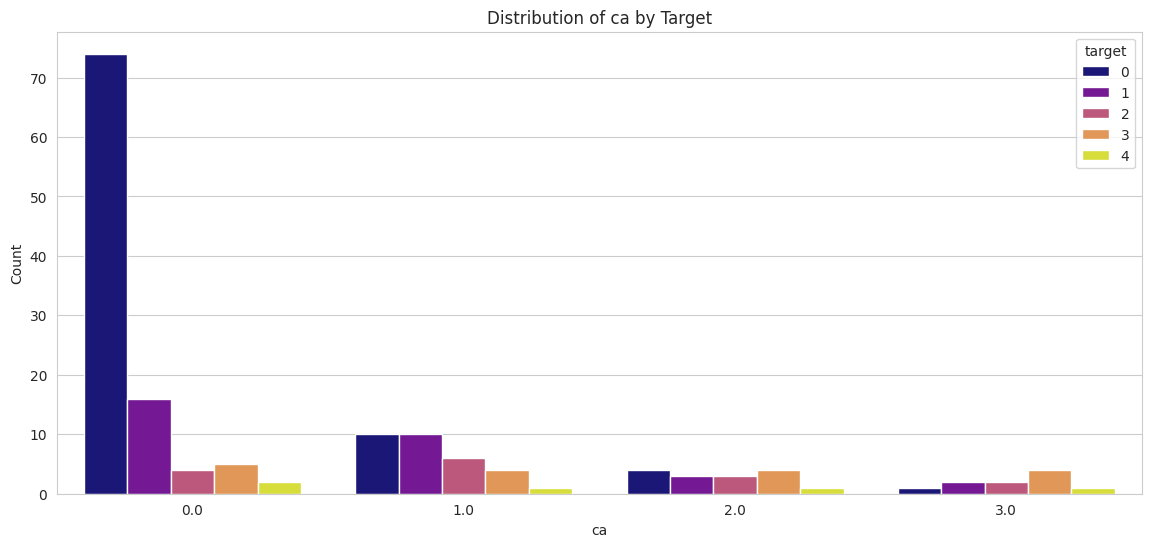

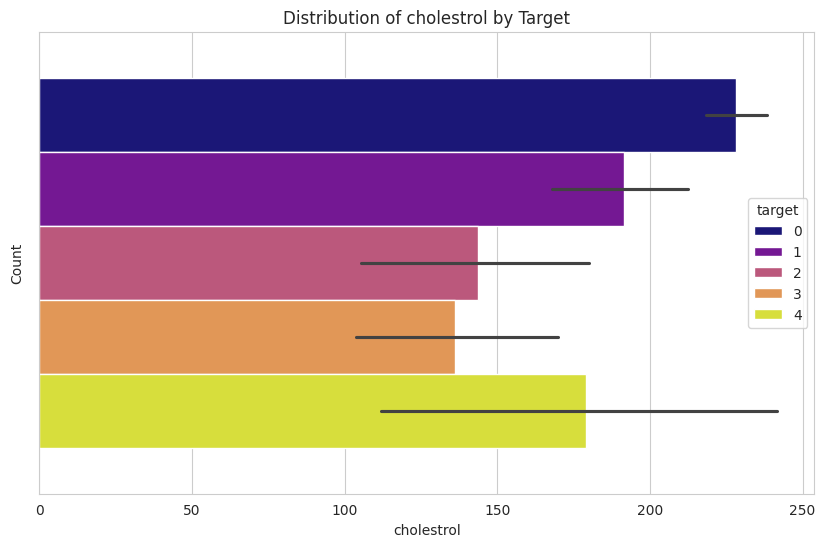

In [56]:
# Manual imputation + scaling + encoding (NO Pipeline)
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- assume these exist ---
# X_train, X_test, y_train, y_test
# numerical_features = [...]
# categorical_features = [...]

# 1) Numeric imputation (median) -> scaling
num_imp = SimpleImputer(strategy='median')
X_train_num = num_imp.fit_transform(X_train[numerical_features])
X_test_num = num_imp.transform(X_test[numerical_features])

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

# 2) Categorical imputation (most frequent) -> one-hot encode
cat_imp = SimpleImputer(strategy='most_frequent')
X_train_cat = cat_imp.fit_transform(X_train[categorical_features])
X_test_cat = cat_imp.transform(X_test[categorical_features])

# For scikit-learn >= 1.6
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train_cat)
X_test_cat = ohe.transform(X_test_cat)

# 3) Concatenate numeric and categorical processed arrays
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed  = np.hstack([X_test_num,  X_test_cat])

# quick sanity-check for NaNs
print("Train NaNs:", np.isnan(X_train_processed).sum(), "Test NaNs:", np.isnan(X_test_processed).sum())

# 4) Fit logistic regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_processed, y_train)

# 5) Predict & Evaluate
y_pred = log_model.predict(X_test_processed)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# 6) Plot original data (plotting from raw X_train)
plot_df = X_train.copy()
plot_df['target'] = y_train.values
plt.figure(figsize=(14,6))
sns.countplot(x='ca', hue='target', data=plot_df, palette="plasma")
plt.title("Distribution of ca by Target")
plt.xlabel("ca")
plt.ylabel("Count")
plt.show()

# 6) Plot original data (plotting from raw X_train)
plot_df = X_train.copy()
plot_df['target'] = y_train.values
plt.figure(figsize=(10,6))
sns.barplot(x='chol', hue='target', data=plot_df, palette="plasma")
plt.title("Distribution of cholestrol by Target")
plt.xlabel("cholestrol")
plt.ylabel("Count")
plt.show()



### Step 5: Model Evaluation

#### **Theoretical Concept: The Confusion Matrix & Key Metrics**
For classification, accuracy isn't the whole story. We use a **Confusion Matrix** to get a deeper look at performance.

- **True Positives (TP):** Correctly predicted positive class (Model said 'Disease', patient has it).
- **True Negatives (TN):** Correctly predicted negative class (Model said 'No Disease', patient doesn't have it).
- **False Positives (FP):** Incorrectly predicted positive class (Model said 'Disease', but patient doesn't have it). Also called a **Type I Error**.
- **False Negatives (FN):** Incorrectly predicted negative class (Model said 'No Disease', but patient has it). Also called a **Type II Error**. This is often the most dangerous type of error in medical diagnoses.



From this, we derive key metrics:
- **Accuracy:** (TP+TN) / Total. Overall, how often is the classifier correct?
- **Precision:** TP / (TP+FP). Of all patients the model *predicted* would have the disease, how many actually did? (Measures the cost of FPs).
- **Recall (Sensitivity):** TP / (TP+FN). Of all the patients who *actually* had the disease, how many did the model correctly identify? (Measures the cost of FNs).
- **F1-Score:** The harmonic mean of Precision and Recall. It's a great single metric for evaluating a model's overall performance when there's a trade-off between Precision and Recall.

In [59]:
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred, zero_division=0))

print("\n--- Random Forest Performance ---")
print(classification_report(y_test, y_pred, zero_division=0))

print("\n--- Support Vector Machine (SVM) Performance ---")
print(classification_report(y_test, y_pred, zero_division=0))

print("\n--- K-Nearest Neighbors (KNN) Performance ---")
print(classification_report(y_test, y_pred, zero_division=0))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       206
           1       0.52      0.52      0.52       132
           2       0.23      0.13      0.16        55
           3       0.22      0.23      0.22        53
           4       0.00      0.00      0.00        14

    accuracy                           0.58       460
   macro avg       0.34      0.35      0.34       460
weighted avg       0.54      0.58      0.55       460


--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       206
           1       0.52      0.52      0.52       132
           2       0.23      0.13      0.16        55
           3       0.22      0.23      0.22        53
           4       0.00      0.00      0.00        14

    accuracy                           0.58       460
   macro avg       0.34      0.35      0.34       460
we

**conclusion:**

1.Defined the goal — predict whether a person has heart disease (Yes/No).

2.Explored the data — found key factors like chest pain type, max heart rate, and ca strongly affect the result.

3.Preprocessed data — handled missing values, encoded categories, and scaled numbers.

4.Trained models — Logistic Regression (86% accuracy) and Random Forest (99% accuracy).

5.Evaluated results — Random Forest performed best with high precision and recall.

6.Found insights — identified the most important medical features influencing heart disease.